<a href="https://colab.research.google.com/github/mobarakol/tutorial_notebooks/blob/main/pose_solvePnP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Head Pose Estimation using OpenCV
src:https://learnopencv.com/head-pose-estimation-using-opencv-and-dlib/

#What is pose estimation ?
In computer vision the pose of an object refers to its relative orientation and position with respect to a camera. You can change the pose by either moving the object with respect to the camera, or the camera with respect to the object.

The pose estimation problem described in this tutorial is often referred to as Perspective-n-Point problem or PNP in computer vision jargon. As we shall see in the following sections in more detail, in this problem the goal is to find the pose of an object when we have a calibrated camera, and we know the locations of n 3D points on the object and the corresponding 2D projections in the image.



#How to mathematically represent camera motion ?
A 3D rigid object has only two kinds of motions with respect to a camera.

Translation : Moving the camera from its current 3D location (X, Y, Z) to a new 3D location (X', Y', Z') is called translation. As you can see translation has 3 degrees of freedom — you can move in the X, Y or Z direction. Translation is represented by a vector \mathbf{t} which is equal to ( X' - X, Y' - Y, Z' - Z ).<br>
Rotation : You can also rotate the camera about the X, Y and Z axes. A rotation, therefore, also has three degrees of freedom. There are many ways of representing rotation. You can represent it using Euler angles ( roll, pitch and yaw ), a 3\times3 rotation matrix, or a direction of rotation (i.e. axis ) and angle.<br>
So, estimating the pose of a 3D object means finding 6 numbers — three for translation and three for rotation.



#What do you need for pose estimation ?
<img src=https://learnopencv.com/wp-content/uploads/2016/09/pose-estimation-requirements-opencv.jpg>


To calculate the 3D pose of an object in an image you need the following information

2D coordinates of a few points : You need the 2D (x,y) locations of a few points in the image. In the case of a face, you could choose the corners of the eyes, the tip of the nose, corners of the mouth etc. Dlib’s facial landmark detector provides us with many points to choose from. In this tutorial, we will use the tip of the nose, the chin, the left corner of the left eye, the right corner of the right eye, the left corner of the mouth, and the right corner of the mouth.

3D locations of the same points : You also need the 3D location of the 2D feature points. You might be thinking that you need a 3D model of the person in the photo to get the 3D locations. Ideally yes, but in practice, you don’t. A generic 3D model will suffice. Where do you get a 3D model of a head from ? Well, you really don’t need a full 3D model. You just need the 3D locations of a few points in some arbitrary reference frame. In this tutorial, we are going to use the following 3D points.
Tip of the nose : ( 0.0, 0.0, 0.0)
Chin : ( 0.0, -330.0, -65.0)
Left corner of the left eye : (-225.0f, 170.0f, -135.0)
Right corner of the right eye : ( 225.0, 170.0, -135.0)
Left corner of the mouth : (-150.0, -150.0, -125.0)
Right corner of the mouth : (150.0, -150.0, -125.0)
Note that the above points are in some arbitrary reference frame / coordinate system. This is called the World Coordinates ( a.k.a Model Coordinates in OpenCV docs ) .

Intrinsic parameters of the camera. As mentioned before, in this problem the camera is assumed to be calibrated. In other words, you need to know the focal length of the camera, the optical center in the image and the radial distortion parameters. So you need to calibrate your camera. Of course, for the lazy dudes and dudettes among us, this is too much work. Can I supply a hack ? Of course, I can! We are already in approximation land by not using an accurate 3D model. We can approximate the optical center by the center of the image, approximate the focal length by the width of the image in pixels and assume that radial distortion does not exist. Boom! you did not even have to get up from your couch!

In [10]:
import requests
hdr = {'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',}
with requests.Session() as session:
    resp_2 = session.get("https://learnopencv.com/wp-content/uploads/2016/09/headPose.jpg", headers=hdr)
    with open("headPose.jpg","wb") as f:
        f.write(resp_2.content)

Camera Matrix :
 [[1.200e+03 0.000e+00 6.000e+02]
 [0.000e+00 1.200e+03 3.375e+02]
 [0.000e+00 0.000e+00 1.000e+00]]
Rotation Vector:
 [[-0.05800198]
 [ 2.20224639]
 [ 0.01942058]]
Translation Vector:
 [[  449.51968738]
 [  -94.74161089]
 [-2343.96945188]]


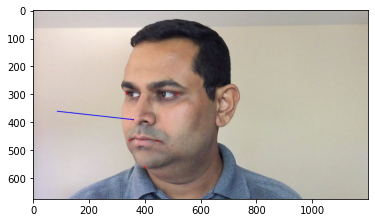

In [17]:
#!/usr/bin/env python
 
import cv2
import numpy as np
import matplotlib.pyplot as plt
 
# Read Image
im = cv2.imread("headPose.jpg");
size = im.shape
 
#2D image points. If you change the image, you need to change vector
image_points = np.array([
                            (359, 391),     # Nose tip
                            (399, 561),     # Chin
                            (337, 297),     # Left eye left corner
                            (513, 301),     # Right eye right corne
                            (345, 465),     # Left Mouth corner
                            (453, 469)      # Right mouth corner
                        ], dtype="double")
 
# 3D model points.
model_points = np.array([
                            (0.0, 0.0, 0.0),             # Nose tip
                            (0.0, -330.0, -65.0),        # Chin
                            (-225.0, 170.0, -135.0),     # Left eye left corner
                            (225.0, 170.0, -135.0),      # Right eye right corne
                            (-150.0, -150.0, -125.0),    # Left Mouth corner
                            (150.0, -150.0, -125.0)      # Right mouth corner
 
                        ])
 
# Camera internals
 
focal_length = size[1]
center = (size[1]/2, size[0]/2)
camera_matrix = np.array(
                         [[focal_length, 0, center[0]],
                         [0, focal_length, center[1]],
                         [0, 0, 1]], dtype = "double"
                         )
 
print( "Camera Matrix :\n {0}".format(camera_matrix))
 
dist_coeffs = np.zeros((4,1)) # Assuming no lens distortion
(success, rotation_vector, translation_vector) = cv2.solvePnP(model_points, image_points, camera_matrix, dist_coeffs, flags=cv2.SOLVEPNP_ITERATIVE)
 
print ("Rotation Vector:\n {0}".format(rotation_vector))
print ("Translation Vector:\n {0}".format(translation_vector))
 
# Project a 3D point (0, 0, 1000.0) onto the image plane.
# We use this to draw a line sticking out of the nose
 
(nose_end_point2D, jacobian) = cv2.projectPoints(np.array([(0.0, 0.0, 1000.0)]), rotation_vector, translation_vector, camera_matrix, dist_coeffs)
 
for p in image_points:
    cv2.circle(im, (int(p[0]), int(p[1])), 3, (0,0,255), -1)
 
p1 = ( int(image_points[0][0]), int(image_points[0][1]))
p2 = ( int(nose_end_point2D[0][0][0]), int(nose_end_point2D[0][0][1]))
 
cv2.line(im, p1, p2, (255,0,0), 2)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im)